In [85]:
# Check logits
import os
import matplotlib.pyplot as plt

    folder_path =   '/network/scratch/s/sonia.joseph/imagenet_logits'
    for entry in os.listdir(folder_path):
        file_path = os.path.join(folder_path, entry)
        if os.path.isfile(file_path):
            print(f"File: {entry}")
        elif os.path.isdir(file_path):
            print(f"Folder: {entry}")

Folder: layer8_head9
Folder: layer0_head0
Folder: unablated
Folder: layer0_head1
Folder: layer0_mlp
Folder: layer1_mlp
Folder: layer2_mlp
Folder: layer3_mlp
Folder: layer0_head2
Folder: layer4_mlp
Folder: layer0_head3
Folder: layer5_mlp
Folder: layer0_head4
Folder: layer6_mlp
Folder: layer0_head5
Folder: layer7_mlp
Folder: layer0_head6
Folder: layer8_mlp
Folder: layer0_head7
Folder: layer0_head8
Folder: layer9_mlp
Folder: layer0_head9
Folder: layer10_mlp
Folder: layer0_head10
Folder: layer11_mlp
Folder: layer0_head11
Folder: layer1_head0
Folder: layer1_head1
Folder: layer1_head2
Folder: layer1_head3
Folder: layer1_head4
Folder: layer1_head5
Folder: layer1_head6
Folder: layer1_head7
Folder: layer1_head8
Folder: layer1_head9
Folder: layer1_head10
Folder: layer1_head11
Folder: layer2_head0
Folder: layer2_head1
Folder: layer2_head2
Folder: layer2_head3
Folder: layer2_head4
Folder: layer2_head5
Folder: layer2_head6
Folder: layer2_head7
Folder: layer2_head8
Folder: layer2_head9
Folder: layer

In [74]:
import json

# Path to your imagenet_class.json file
json_file_path = '/home/mila/s/sonia.joseph/ViT-Planetarium/my_draft/test_nbs/imagenet_class_index.json'


# Load the JSON file into a Python dictionary
with open(json_file_path, 'r') as file:
    num_to_word_dict = json.load(file)

# Create a reverse dictionary for word to number mapping
word_to_num_dict = {}
for num, words in num_to_word_dict.items():
    for word in words:  # Assuming each entry in num_to_word_dict is a list of words
        word_to_num_dict[word] = num

# Function to get the class name from a label
def get_class_name(label):
    # Assuming the label maps to a list of class names
    return num_to_word_dict.get(str(label), ["Unknown label"])[1]

# Function to get the label from a class name
def get_label(class_name):
    return word_to_num_dict.get(class_name, "Unknown class name")

# Example usage
label = 0  # Replace with your label
class_name = get_class_name(label)
print(f"Class for label {label}: {class_name}")

class_name_to_lookup = "tiger_cat"  # Replace with your class name
label_from_class_name = get_label(class_name_to_lookup)
print(f"Label for class name '{class_name_to_lookup}': {label_from_class_name}")


Class for label 0: tench
Label for class name 'tiger_cat': 282


In [68]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
import logging

# Path to your ImageNet dataset
imagenet_path = '/network/datasets/imagenet.var/imagenet_torchvision/val/'

# Transformation for the data
data_transforms = transforms.Compose([
    # Add your transformations here
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the ImageNet dataset
imagenet_data = datasets.ImageFolder(imagenet_path, transform=data_transforms)

# Function to get subset of dataset for a specific label
def get_subset_for_label(dataset, label_idx):
    # Find the index of the label
#     label_idx = dataset.class_to_idx[label]

    # Get indices of images with the specific label
    target_indices = [i for i, (_, target) in enumerate(dataset.samples) if target == label_idx]

    # Create a subset
    return Subset(dataset, target_indices)

# Specify your label here (folder name)
num_label = 'Egyptian_cat'
specific_label = int(get_label(num_label))
print(specific_label)

# Get the subset for the specific label
specific_label_subset = get_subset_for_label(imagenet_data, specific_label)

# Create a DataLoader for the subset
data_loader = DataLoader(specific_label_subset, batch_size=60, shuffle=False)

# Logging
print(f"ImageNet subset for label '{specific_label}' loaded. Total datapoints: {len(specific_label_subset)}")


285
ImageNet subset for label '285' loaded. Total datapoints: 50


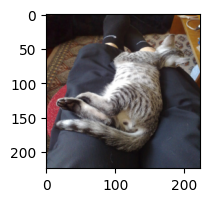

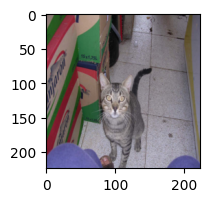

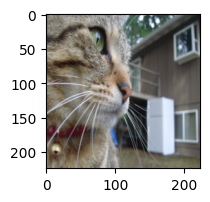

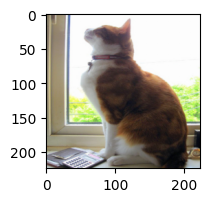

In [75]:
img, label = next(iter(data_loader))

max_count = 4
count = 0
for img, label in data_loader:
    for i in range(max_count):
        plt.figure(figsize=(2,2))
        plt.imshow(img[i].permute(1,2,0))



In [136]:
import h5py
import os
import numpy as np

# Path to your HDF5 file

def read_accuracies_from_file(file_path):
    """
    Reads a .txt file and extracts accuracy values formatted like "Accuracy for Layer 0, Head 0: 0.7198".

    :param file_path: Path to the .txt file.
    :return: A dictionary with the layer and head as keys and the accuracy as values.
    """
    try:
        with open(file_path, 'r') as file:
            for line in file:
                if 'Accuracy for Layer' in line:
                    parts = line.strip().split(',')
                    parts = parts[-1].split(':')
                    acc = parts[-1].strip()
        return float(acc)
    except Exception as e:
        print(f"Error reading file: {e}")

def get_logits(ablation_type='layer0_head0', parent_dir = '/network/scratch/s/sonia.joseph/imagenet_logits/'):
    load_path = os.path.join(parent_dir, ablation_type)
    with h5py.File(os.path.join(load_path, 'logits_and_labels.h5'), 'r') as h5f:
        logits_dataset = h5f['logits']
        labels = h5f['labels']
        indices_of_specific_label = np.where(labels[:] == specific_label)[0]
        specific_logits = logits_dataset[indices_of_specific_label]
    accuracy = read_accuracies_from_file(os.path.join(load_path, 'accuracy.txt'))
    return specific_logits, accuracy




In [170]:
data = np.zeros((24,12))
for idx, layer_idx in enumerate(range(24)):
    print(f"On layer_idx {layer_idx}")
    try:
        if idx % 2 == 0: # attn
            for head_idx in range(12):
                ablation_type = f'layer{layer_idx//2}_head{head_idx}'
                _, acc = get_logits(ablation_type)
                print(acc)
                data[layer_idx, head_idx] = acc
        else:
            ablation_type = f'layer{layer_idx//2}_mlp'
    #         print('mlp', ablation_type)
            _, acc = get_logits(ablation_type)
            print(acc)
            data[layer_idx,:] = acc
    except Exception as e:
        print(e)



On layer_idx 0
0.7198
0.7227
0.718
0.7175
0.7131
0.7252
0.7184
0.7223
0.721
0.723
0.7247
0.7039
On layer_idx 1
0.0406
On layer_idx 2
0.7133
0.6707
0.7188
0.713
0.6874
0.719
0.7188
0.7162
0.7191
0.7133
0.7198
0.719
On layer_idx 3
0.6199
On layer_idx 4
0.7156
0.7151
0.719
0.7151
0.71
0.7137
0.7168
0.7156
0.7131
0.7163
0.7126
0.7188
On layer_idx 5
0.6335
On layer_idx 6
0.7178
0.7116
0.7198
0.7125
0.7101
0.7193
0.7172
0.7087
0.718
0.7189
0.7133
0.7215
On layer_idx 7
0.6166
On layer_idx 8
0.7195
0.7156
0.7188
0.716
0.7181
0.719
0.7175
0.7149
0.7134
0.7183
0.712
0.7184
On layer_idx 9
0.6373
On layer_idx 10
0.7163
0.7102
0.715
0.7089
0.7167
0.7177
0.7174
0.7159
0.7159
0.7188
0.7053
0.7181
On layer_idx 11
0.6445
On layer_idx 12
0.7189
0.715
0.7161
0.7165
0.7182
0.7177
0.7182
0.7171
0.7131
0.7175
0.7095
0.7196
On layer_idx 13
0.6503
On layer_idx 14
0.7168
0.7172
0.7164
0.7124
0.7138
0.7176
0.7179
0.7147
0.7115
0.7162
0.7109
0.7165
On layer_idx 15
0.6502
On layer_idx 16
0.7178
0.7182
0.7188
0.71

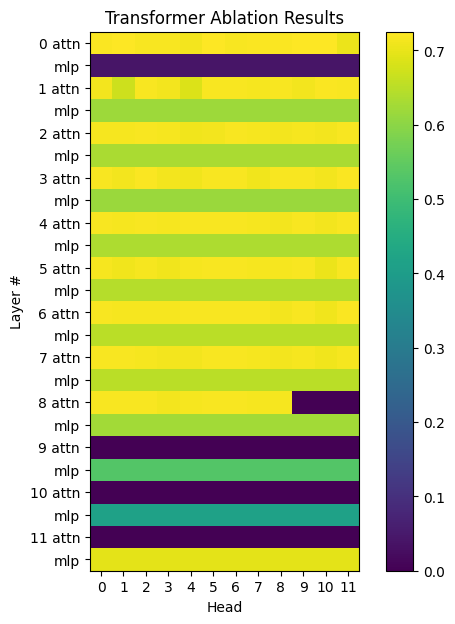

In [190]:
fig, axs = plt.subplots(figsize=(7,7))

axs.set_yticks(np.arange(len(layers)))
axs.set_yticklabels(layers)
axs.set_ylabel('Layer #') 

axs.set_xlabel('Head')
axs.set_xticks(np.arange(len(layers)))
axs.set_title('Transformer Ablation Results')


im = axs.imshow(data[:, :])
cbar = fig.colorbar(im)


452


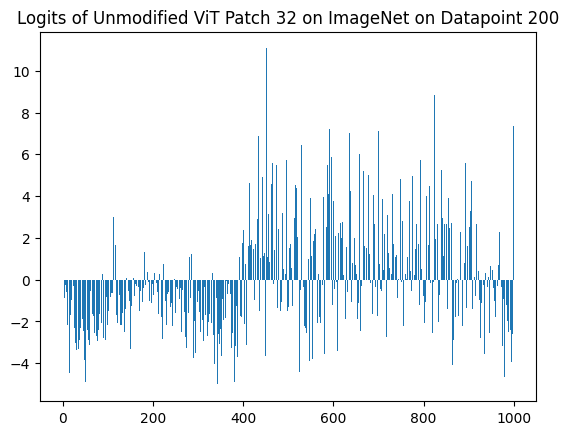

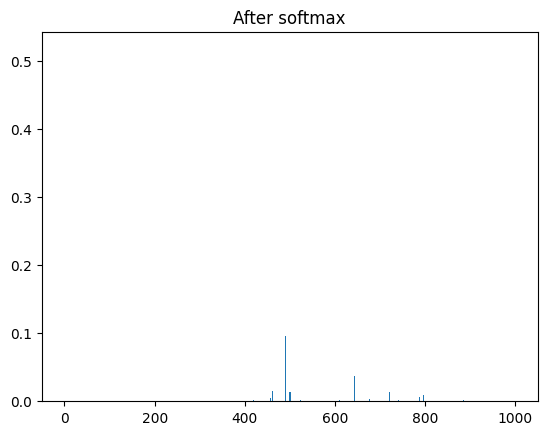

In [36]:
import matplotlib.pyplot as plt

import numpy as np

def softmax_fn(x):
    # Apply softmax to an array (can be a vector or a matrix)
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis=0)

# Open the HDF5 file
with h5py.File(os.path.join(save_path, 'logits_and_labels.h5'), 'r') as h5f:
    # Load the logits dataset
    logits_dataset = h5f['logits']
    labels = h5f['labels']
    
    idx = 200
    print(labels[idx])
        
    plt.figure()
    plt.bar(range(1000),logits_dataset[idx,:])
    plt.title(f"Logits of Unmodified ViT Patch 32 on ImageNet on Datapoint {idx}")
    
    softmax_data = softmax_fn(logits_dataset[idx,:])
    plt.figure()
    plt.bar(range(1000), softmax_data)
    plt.title(f'After softmax')